### transformer breakdown

In [1]:
import torch

/home/kyle/pythonenvs/venv38/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

transformer_model = torch.nn.Transformer(nhead=16, num_encoder_layers=12)

class Net(torch.nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.model = model
        self.encoder = model.encoder # src, mask, src key padding mask
        self.decoder = model.decoder # tgt, memory, tgt mask, memory mask, tgt key padding mask, memory key padding mask


    def forward(self, src, tgt):
        mem = self.encoder(src) # apply M
        output = self.decoder(tgt, mem)
        
        return output

src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
# oi = transformer_model.encoder(src)
# of = transformer_model.decoder(oi, tgt)
# print(oi.shape)
# print(of.shape)
# o1 = transformer_model(src, tgt)
# net = Net(transformer_model)
# o2 = net(src,tgt)
# print('o1 ', o1.shape)
# print('o2 ', o2.shape)
# print(o1)
# print(o2)

In [3]:
transformer_model.encoder.layers[0]

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

### WMT2014 dataset

### pytorch Multi30k tutorial
complete with early stopping and testing with bleu score
only concern is that original transformer arch was not tested on multi30k but on wmt2014 instead

#### setup

try to download a mt dataset, https://pytorch.org/tutorials/beginner/translation_transformer.html

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
import torchdata


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
# pip install -U torchdata
# pip install -U spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [5]:
train_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
# for data_sample in train_iter:
#     # print((data_sample))
#     continue

### model

#### MNet

In [6]:
global lst_sqs_sum
lst_sqs_sum = 0

In [7]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import time


class GradSaver(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, sequentialOutput, saver):
        # print('in forward in grad saver')
        ctx.save_for_backward(x, saver, sequentialOutput)
        return sequentialOutput.clone().detach()

    # @staticmethod
    # def backward(ctx, gradients):
    #     global lst_sqs_sum
    #     # print('gradients in grad saver: ', gradients)
        
    #     x, saver, sequentialOutput, = ctx.saved_tensors
    #     s = time.time()
    #     m = torch.linalg.lstsq(x, sequentialOutput).solution
    #     print(x.shape)
    #     print(sequentialOutput.shape)
    #     # print('saver dtype ', saver.dtype, saver.shape, saver.device)
    #     # print('gradients dtype ', gradients.dtype, gradients.shape, gradients.device)
    #     saver.grad = gradients.clone()#.cpu()
    #     # print('in grad saver ', saver.grad)


    #     # print(gradients.shape, m.shape)
        
    #     z = torch.matmul(gradients, m)#, None, None
    #     # z = torch.bmm(gradients, m)
    #     lst_sqs_sum += (time.time() -s )
    #     # z = torch.matmul(gradients, torch.transpose(m, 0, 1))#, None, None
    #     # print('matmul result in grad saver: ', z)
    #     return z, gradients, None
    
    @staticmethod
    def backward(ctx, gradients):
        global lst_sqs_sum
        # print('gradients in grad saver: ', gradients)
        
        x, saver, sequentialOutput, = ctx.saved_tensors
        s = time.time()
        t = 1e-9
        x_T = torch.transpose(x, -1, 1)
        I = torch.eye(x.shape[1]).to('cuda:1')
        pinv = torch.bmm(x_T, torch.inverse(torch.bmm(x, x_T) + t * I)) 
        m = torch.bmm(pinv, sequentialOutput) # torch.transpose(pinv, -1, 1)

        # print(x.shape)
        # print(sequentialOutput.shape)
        # print('saver dtype ', saver.dtype, saver.shape, saver.device)
        # print('gradients dtype ', gradients.dtype, gradients.shape, gradients.device)
        saver.grad = gradients.clone()#.cpu()
        # print('in grad saver ', saver.grad)


        # print(gradients.shape, m.shape)
        # a = 
        z = torch.bmm(gradients, m)#, None, None
        # z = torch.bmm(gradients, m)
        lst_sqs_sum += (time.time() -s )
        # z = torch.matmul(gradients, torch.transpose(m, 0, 1))#, None, None
        # print('matmul result in grad saver: ', z)
        return z, None, None
    
class MNet_Transformer(torch.nn.Module):
    def __init__(self, sequentialLayers, output_size):
        super(MNet_Transformer, self).__init__()
        self.layers = []
        for l in sequentialLayers:
            # if not isinstance(l, nn.ReLU):
            if True: # insert all layers (attn, linear, dropout, norm)
                # l.requires_grad = True
                self.layers.append(l)
        # self.layers.requires_grad = False
        self.input_x = None
        self.layersOutput = []
        self.saver = torch.ones(output_size, dtype = self.layers[1].weight.dtype, requires_grad=True).to('cuda:1') # check dims of this (batch, output of M) 
        self.gradDiverge = GradSaver.apply

    def getLayersOutput(self, x, mask, padding_mask):
        self.layersOutput = []

        x_clone = x.clone().detach()
        x_clone.requires_grad = False
        self.input_x = x_clone

        lo = x_clone
        for l in self.layers:
            if isinstance(l, nn.MultiheadAttention):
                if padding_mask is not None:
                    lo = l(lo,lo,lo, attn_mask=mask, key_padding_mask=padding_mask)[0] # using attn output only not the attn output weights
                else:
                    lo = l(lo,lo,lo, attn_mask=mask)[0] # using attn output only not the attn output weights
            else:
                lo = l(lo)
            # if lo.requires_grad == False:
                # print('error')
                # print(l)

        return lo

    def forward(self, x, mask, padding_mask):
        x_clone = x.clone().detach()
        x_clone.requires_grad = False
        self.sequentialOutput = self.getLayersOutput(x_clone, mask, padding_mask)
        # self.saver = sequentialOutput.clone().detach()
        if self.saver.shape != self.sequentialOutput.shape:
            self.saver = torch.ones(self.sequentialOutput.shape).to('cuda:1')
        # print('self.sequentialOutput.requires_grad ', self.sequentialOutput.requires_grad)
        # m = torch.linalg.lstsq(x_clone, self.sequentialOutput).solution.detach()
        # o = F.linear(x, torch.transpose(m, 0, 1))
        t = self.gradDiverge(x, self.sequentialOutput.clone().detach(), self.saver)
        
        # print('t, ', t.grad)
        return t

    def backwardHidden(self):
        # print('in MNet, ', self.saver.grad)
        # print('seqoutput grad', self.sequentialOutput.grad)
        self.sequentialOutput.backward(gradient = self.saver.grad.clone().detach())
        
    def get_parameters(self):
        ps = []
        ps.append(self.layers[0].out_proj.weight) # self attn
        ps.append(self.layers[0].out_proj.bias)
        for l in self.layers:
            if hasattr(l, 'weight') and hasattr(l, 'bias'):
                ps.append(l.weight)
                ps.append(l.bias)
        return ps



#### seq2seq transformer arch

In [8]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class CustomSequential(nn.Module):
    def __init__(self, encoder_layers) -> None:
        super(CustomSequential, self).__init__()
        self.encoder_layers = encoder_layers
        modules = []
        for i in range(len(encoder_layers)):
            modules.append(encoder_layers[i].self_attn)
            modules.append(encoder_layers[i].linear1)
            modules.append(encoder_layers[i].dropout)
            modules.append(encoder_layers[i].linear2)
            modules.append(encoder_layers[i].norm1)
            modules.append(encoder_layers[i].norm2)
            modules.append(encoder_layers[i].dropout)
            modules.append(encoder_layers[i].dropout)
            # try to add the layernorms too

        self.custom_sequential = nn.Sequential(*modules)

    # def forward(self, src, src_mask, src_padding_mask):
    #     t = self.encoder_layers[i].self_attn(src, src_mask)

    #     return t

class CustomTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 d_model: int,
                 nhead: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(CustomTransformer, self).__init__()
        self.model = Transformer(d_model=d_model,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.batch_size = 128
        # print('pre mnet init')
        # self.MNet1 = MNet(nn.Sequential(self.model.encoder.layers[1], self.model.encoder.layers[2][0], self.model.encoder.layers[3][0], self.model.encoder.layers[4][0]), (self.batch_size, 512))
        # self.MNet2 = MNet(nn.Sequential(self.model.encoder.layers[6], self.model.encoder.layers[7], self.model.encoder.layers[8], self.model.encoder.layers[9]), (self.batch_size, 512))
        self.MNet1 = MNet_Transformer(CustomSequential(self.model.encoder.layers[1:5]).custom_sequential, (self.batch_size, 512))
        self.MNet2 = MNet_Transformer(CustomSequential(self.model.encoder.layers[6:-1]).custom_sequential, (self.batch_size, 512))

        # print('post mnet init')

    def fi(self, encoder_layer, src, src_mask, src_padding_mask,):
        # this works and is the proper way to apply self attn in the encoder and to apply the masks (i think)
        if src_padding_mask is not None:
            t = encoder_layer.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_padding_mask)[0] # not returning the attn output weights
        else:
            t = encoder_layer.self_attn(src, src, src, attn_mask=src_mask,)[0] # not returning the attn output weights
        # print('in fi')
        # print(len(t))
        # print(t)
        t = encoder_layer.linear1(t)
        t = encoder_layer.dropout(t)
        t = encoder_layer.linear2(t)
        t = encoder_layer.norm1(t)
        t = encoder_layer.norm2(t)
        t = encoder_layer.dropout(t)
        t = encoder_layer.dropout(t)
        return t

    def custom_encode(self, src, src_mask, src_padding_mask):
        t = src
        t = self.fi(self.model.encoder.layers[0], src, src_mask, src_padding_mask)
        # t = self.model.encoder.layers[0](t, attn_mask=src_mask, key_padding_mask=src_padding_mask)
        # print('here', t.shape)
        # print(t)
        t = self.MNet1(t, src_mask, src_padding_mask)
        t = self.fi(self.model.encoder.layers[5], src, src_mask, src_padding_mask)
        t = self.MNet2(t, src_mask, src_padding_mask)
        t = self.fi(self.model.encoder.layers[-1], src, src_mask, src_padding_mask)

        return t

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        # mem = self.model.encoder(src) # apply M
        t = src
        t = self.fi(self.model.encoder.layers[0], src, src_mask, src_padding_mask)
        # t = self.model.encoder.layers[0](t, attn_mask=src_mask, key_padding_mask=src_padding_mask)
        # print('here', t.shape)
        # print(t)
        t = self.MNet1(t, src_mask, src_padding_mask)
        t = self.fi(self.model.encoder.layers[5], t, src_mask, src_padding_mask)
        t = self.MNet2(t, src_mask, src_padding_mask)
        # print('forward in custom transformer, ', t.requires_grad)
        t = self.fi(self.model.encoder.layers[-1], t, src_mask, src_padding_mask)



        mem = t #(in this case just the src padding mask which is boolean)
        output = self.model.decoder(tgt, mem, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        
        return output
    
    def get_parameters(self):
        ps = []
        mnet1Ps = self.MNet1.get_parameters()
        mnet2Ps = self.MNet2.get_parameters()
        

        # add params outside of layers abstracted by Ms in encoder and decoder
        kept_encoder_layers = [self.model.encoder.layers[0], self.model.encoder.layers[5], self.model.encoder.layers[-1]]
        for kept_layer in kept_encoder_layers:
            ps.append(kept_layer.self_attn.out_proj.weight)
            ps.append(kept_layer.self_attn.out_proj.bias)
            ps.append(kept_layer.linear1.weight)
            ps.append(kept_layer.linear1.bias)
            ps.append(kept_layer.linear2.weight)
            ps.append(kept_layer.linear2.bias)

        for block in self.model.decoder.layers:
            ps.append(block.self_attn.out_proj.weight)
            ps.append(block.self_attn.out_proj.bias)
            ps.append(block.multihead_attn.out_proj.weight)
            ps.append(block.multihead_attn.out_proj.bias)
            ps.append(block.linear1.weight)
            ps.append(block.linear1.bias)
            ps.append(block.linear2.weight)
            ps.append(block.linear2.bias)
            

        for p in mnet1Ps:
            ps.append(p)
        for p in mnet2Ps:
            ps.append(p)
        return ps

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = CustomTransformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size) # not returning the attn output weights
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        # print('src_emb.shape ', src_emb.shape)
        # print('src_mask.shape ', src_mask.shape)
        # print('src_emb ', src_emb)
        # print('src_mask ', src_mask)
        # exit(0)
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask) # find out how masking is applied within forward method
        return self.generator(outs)
    
    def get_parameters(self):
        ps = []
        transformer_ps = self.transformer.get_parameters()
        ps += transformer_ps
        ps.append(self.generator.weight)
        ps.append(self.generator.bias)
        ps.append(self.src_tok_emb.embedding.weight)
        ps.append(self.tgt_tok_emb.embedding.weight)

        return ps

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

#### masking

In [9]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

#### training setup

In [10]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 12
NUM_DECODER_LAYERS = 6

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to('cuda:1')

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
# lr = 0.0007 
lr = 0.0001
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
# optimizer = torch.optim.Adam(transformer.get_parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

#### batching

In [11]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

#### training func

In [12]:
from torch.utils.data import DataLoader
from threading import Thread

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train_epoch(model, optimizer):
    model.train()
    losses = 0
    saved_losses = []
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        # if src.shape[1] != BATCH_SIZE:
        #     print('not skipping batch of size ',src.shape[1])
        #     # continue 
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        model.transformer.MNet1.backwardHidden()
        model.transformer.MNet2.backwardHidden()

        # a = model.transformer.MNet1.layers[0].out_proj.weight.grad
        # # print('grad of self attn in MNet1, ', a)

        # a = model.transformer.MNet1.layers[1].weight.grad
        # print('grad of linear1 in MNet1, ', a)

        # # print()
        # a = model.transformer.model.encoder.layers[0].linear1.weight.grad
        # print('grad of linear in regular layer0, ', a)
        
        
        # a = model.transformer.model.encoder.layers[-1].linear1.weight.grad
        # print('grad of linear in regular layer-1, ', a)

        # print("FINISHED ONE BATCH!")
        optimizer.step()
        losses += loss.item()
        saved_losses.append(loss.item())

    return losses / len(list(train_dataloader)), saved_losses

def update1(network):
  network.MNet1.backwardHidden() 

def update2(network):
  network.MNet2.backwardHidden() 

def train_epoch_parallel(model, optimizer):
    model.train()
    losses = 0
    saved_losses = []
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        # if src.shape[1] != BATCH_SIZE:
        #     print('not skipping batch of size ',src.shape[1])
        #     # continue 
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        # print('before general backward')
        loss.backward()

        # check if first encoder layer has grad
        # g = model.transformer.model.encoder.layers[5].linear1.weight.grad
        # print('g ', g)
        # parallelized update
        p1 = Thread(target=update1, args=[model.transformer]) # start two independent threads
        # p2 = Thread(target=update2, args=[model.transformer]) # start two independent threads
        
        p1.start()
        # p2.start()
        model.transformer.MNet2.backwardHidden()


        p1.join()
        # p2.join()

        # print('before mnet backwards')
        # model.transformer.MNet1.backwardHidden()
        
        # wait for both MNets to finish updating

        # a = model.transformer.MNet1.layers[0].out_proj.weight.grad
        # print('grad of self attn in MNet1, ', a)

        optimizer.step()
        losses += loss.item()
        saved_losses.append(loss.item())

    return losses / len(list(train_dataloader)), saved_losses


def evaluate(model):
    model.eval()
    losses = 0
    saved_losses_val = []
    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        saved_losses_val.append(loss.item())

    return losses / len(list(val_dataloader)), saved_losses_val

#### training loop

In [13]:
from timeit import default_timer as timer
import time
import numpy as np

NUM_EPOCHS = 18
DEVICE = 'cuda:1'
PATH = 'seq2seq_transformer_multi30k_weights.pt'
try:
    raise Exception
    transformer.load_state_dict(torch.load(PATH))
    print('Transformer model weights loaded')
except Exception:
    # early_stopper = EarlyStopper(patience=3, min_delta=0.025)
    t0 = time.time()
    training_losses_to_plot = []
    val_losses_to_plot = []
    for epoch in range(1, NUM_EPOCHS+1):
        start_time = timer()
        train_loss, saved_losses_train = train_epoch_parallel(transformer, optimizer)
        # train_loss, saved_losses_train = train_epoch(transformer, optimizer)
        end_time = timer()
        val_loss, saved_losses_val = evaluate(transformer)
        print('M computation TIME PER EPOCH: ', lst_sqs_sum)
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
        lst_sqs_sum = 0
        training_losses_to_plot += saved_losses_train
        val_losses_to_plot += saved_losses_val
        # if early_stopper.early_stop(val_loss):
        #     print("<EARLY STOP> model done training.")             
        #     break
    tf = time.time()
    PATH = f'seq2seq_transformer_multi30k_weights_epochs={epoch}.pt'
    torch.save(transformer.state_dict(), PATH)
    print(f'Transformer model saved ({PATH})')
    print(f'Trained for {NUM_EPOCHS} epochs in {tf - t0} seconds')

M computation TIME PER EPOCH:  12.515054702758789
Epoch: 1, Train loss: 5.559, Val loss: 4.426, Epoch time = 39.642s
M computation TIME PER EPOCH:  12.898427248001099
Epoch: 2, Train loss: 4.184, Val loss: 3.994, Epoch time = 39.263s
M computation TIME PER EPOCH:  12.848719120025635
Epoch: 3, Train loss: 3.879, Val loss: 3.825, Epoch time = 39.649s
M computation TIME PER EPOCH:  12.892463207244873
Epoch: 4, Train loss: 3.707, Val loss: 3.728, Epoch time = 39.731s
M computation TIME PER EPOCH:  13.016301155090332
Epoch: 5, Train loss: 3.581, Val loss: 3.659, Epoch time = 39.768s
M computation TIME PER EPOCH:  12.942612886428833
Epoch: 6, Train loss: 3.478, Val loss: 3.621, Epoch time = 39.750s
M computation TIME PER EPOCH:  12.98859453201294
Epoch: 7, Train loss: 3.392, Val loss: 3.576, Epoch time = 39.481s
M computation TIME PER EPOCH:  12.848305702209473
Epoch: 8, Train loss: 3.316, Val loss: 3.549, Epoch time = 40.139s
M computation TIME PER EPOCH:  12.835210800170898
Epoch: 9, Train

To improve training further, can use adaptive learning rate schedule as described in sec 5.3 and also label smoothing as described in sec 5.4

#### plotting curves

ValueError: x and y must have same first dimension, but have shapes (6,) and (144,)

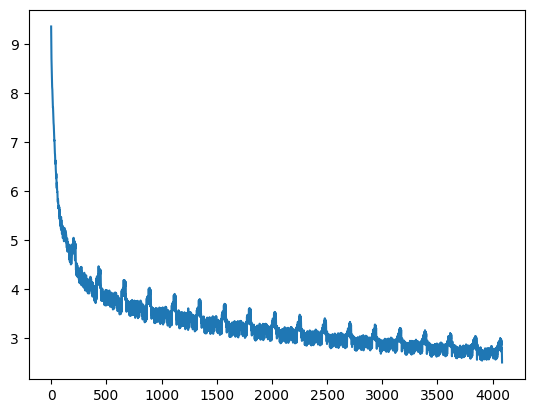

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

s = (len(training_losses_to_plot) // len(val_losses_to_plot)) 

plt.plot(np.arange(0, len(training_losses_to_plot), 1), training_losses_to_plot)
plt.plot(np.arange(0, len(val_losses_to_plot), s), val_losses_to_plot)
plt.show()

#### testing

In [ ]:
from torchmetrics.functional import bleu_score

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encoder(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# function to generate output sequence using greedy algorithm
def greedy_decode_MNet(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    # print(src.shape)
    src_emb = model.positional_encoding(model.src_tok_emb(src))
    # print(src_emb.shape)
    memory = model.transformer.custom_encode(src_emb, src_mask, None)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        ys_emb = model.positional_encoding(model.tgt_tok_emb(ys))
        out = model.transformer.model.decoder(ys_emb, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

# actual function to translate input sentence into target language
def translate_MNet(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    # print('in translate, ', src.shape)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode_MNet(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

def test(model,):
    test_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    
    # compute the avg bleu score
    bleu = 0
    ct = 0
    for data_sample in test_iter:
        ct += 1
        # print(data_sample)
        src = data_sample[0]
        tgt = data_sample[1]
        pred = translate_MNet(model, src)
        bleu += bleu_score([pred], [tgt])
    return bleu / ct


In [ ]:
test(transformer)

tensor(0.0151)

In [ ]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))
print(translate(transformer, "Wie gehen Sie?"))
print(translate(transformer, "Ich heisse Hermann"))

AttributeError: 'Seq2SeqTransformer' object has no attribute 'encoder'

In [ ]:

# A group of people stand in front of an auditorium
# candidate_corpus = [['A', 'group', 'of', 'people', 'stand', 'in', 'front', 'of', 'an', 'auditorium'], ['Wie', 'gehen', 'Sie']]
candidate_corpus = ['A group of people stand in front of an auditorium']
# references_corpus = [['A', 'group', 'of', 'people', 'stand', 'in', 'front', 'of', 'an', 'igloo'], ['How', 'are', 'you'], ['No', 'Match']]
references_corpus = [['A group of people stand in front of an igloo']]
score = bleu_score(candidate_corpus, references_corpus)
print(f'BLEU score for ref_corpus: {references_corpus}, score: {score}')